# **7. Bài toán chuỗi thơi gian**

## **7.1. Mục tiêu**
* Dùng SARIMAX để theo dỡi đánh giá xu hướng thời gian
* Sử dụng các thang số để đánh giá độ chính xác dự đoán
* Tim được ý nghĩa thống tê của các dặc trưng
* Khả năng dự đoán được công suất phòng trong 90 ngày tới

## **7.2. Nạp thư viện & load dữ liệu**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [32]:
train_df = pd.read_csv('hotel_booking_timeseries_train.csv')
test_df = pd.read_csv('hotel_booking_timeseries_test.csv')

In [33]:
train_df.shape, test_df.shape

((628, 12), (158, 12))

In [34]:
train_df.head()

,arrival_date,bookings,canceled,adr_mean,lead_time_mean,guests_mean,dow,month,weekofyear,bookings_lag7,bookings_ma7,cancel_rate
0,2015-07-08,69,24,79.991594,171.028986,2.014493,2,7,28,122.0,69.714286,0.347826
1,2015-07-09,80,51,80.648000,180.550000,2.112500,3,7,28,93.0,67.857143,0.637500
2,2015-07-10,51,9,111.997451,73.333333,2.352941,4,7,28,56.0,67.142857,0.176471
3,2015-07-11,103,42,98.874951,111.194175,2.029126,5,7,28,88.0,69.285714,0.407767
4,2015-07-12,63,26,110.419841,110.365079,2.380952,6,7,28,53.0,70.714286,0.412698


In [35]:
test_df.head()

,arrival_date,bookings,canceled,adr_mean,lead_time_mean,guests_mean,dow,month,weekofyear,bookings_lag7,bookings_ma7,cancel_rate
0,2017-03-27,183,69,82.122240,92.825137,1.857923,0,3,13,167.0,147.000000,0.377049
1,2017-03-28,88,21,78.851136,61.102273,1.806818,1,3,13,153.0,137.714286,0.238636
2,2017-03-29,154,24,78.192792,44.642857,1.740260,2,3,13,90.0,146.857143,0.155844
3,2017-03-30,177,55,85.409379,116.988701,1.824859,3,3,13,146.0,151.285714,0.310734
4,2017-03-31,213,83,96.227981,71.436620,1.985915,4,3,13,189.0,154.714286,0.389671


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   arrival_date    628 non-null    object 
 1   bookings        628 non-null    int64  
 2   canceled        628 non-null    int64  
 3   adr_mean        628 non-null    float64
 4   lead_time_mean  628 non-null    float64
 5   guests_mean     628 non-null    float64
 6   dow             628 non-null    int64  
 7   month           628 non-null    int64  
 8   weekofyear      628 non-null    int64  
 9   bookings_lag7   628 non-null    float64
 10  bookings_ma7    628 non-null    float64
 11  cancel_rate     628 non-null    float64
dtypes: float64(6), int64(5), object(1)
memory usage: 59.0+ KB


## **7.3. Phân tích chuỗi thời gian**

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  628
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3181.996
Date:                           Tue, 23 Dec 2025   AIC                           6397.992
Time:                                   19:57:50   BIC                           6473.048
Sample:                               07-08-2015   HQIC                          6427.186
                                    - 03-26-2017                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
adr_mean           0.2292      0.158      1.449      0.147      -0.081       0.539
lead_time_mean     0.4432      

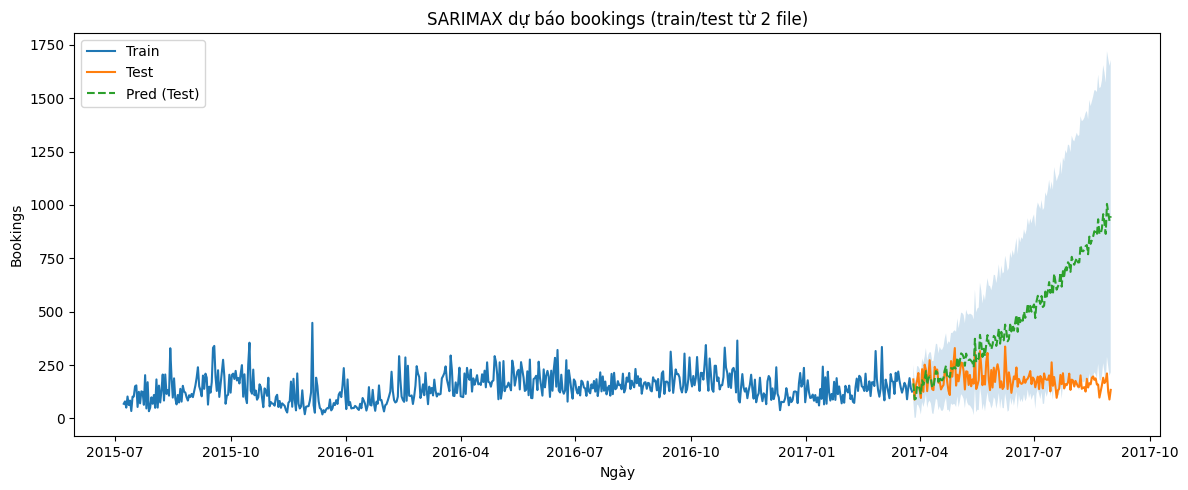

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


# =========================
# 1) PREP: SORT + INDEX
# =========================
def prep_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["arrival_date"] = pd.to_datetime(df["arrival_date"])
    df = df.sort_values("arrival_date").set_index("arrival_date")
    return df

train_ts = prep_index(train_df)
test_ts  = prep_index(test_df)

# Target
y_train = train_ts["bookings"].astype(float)
y_test  = test_ts["bookings"].astype(float)

# =========================
# 2) FEATURE ENGINEERING
#    - Cyclical encoding cho dow/month/weekofyear
#    - Tự tạo cancel_rate, lag7, ma7 nếu thiếu
# =========================
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Nếu thiếu cột dow/month/weekofyear thì tự tạo từ index
    if "dow" not in df.columns:
        df["dow"] = df.index.dayofweek
    if "month" not in df.columns:
        df["month"] = df.index.month
    if "weekofyear" not in df.columns:
        df["weekofyear"] = df.index.isocalendar().week.astype(int)

    # Cancel rate
    if "cancel_rate" not in df.columns:
        if "canceled" in df.columns and "bookings" in df.columns:
            den = df["bookings"].replace(0, np.nan)
            df["cancel_rate"] = (df["canceled"] / den).fillna(0.0)
        else:
            df["cancel_rate"] = 0.0

    # Lag / Moving average (an toàn)
    if "bookings_lag7" not in df.columns:
        df["bookings_lag7"] = df["bookings"].astype(float).shift(7)
    if "bookings_ma7" not in df.columns:
        df["bookings_ma7"] = df["bookings"].astype(float).shift(1).rolling(7).mean()

    # Cyclical encoding (giảm số chiều, ổn định hơn one-hot)
    df["dow_sin"]   = np.sin(2 * np.pi * df["dow"] / 7)
    df["dow_cos"]   = np.cos(2 * np.pi * df["dow"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["woy_sin"]   = np.sin(2 * np.pi * df["weekofyear"] / 52)
    df["woy_cos"]   = np.cos(2 * np.pi * df["weekofyear"] / 52)

    return df

train_feat = add_features(train_ts)
test_feat  = add_features(test_ts)

# =========================
# 3) BUILD EXOG (đồng nhất cột train/test)
# =========================
EXOG_COLS = [
    "adr_mean", "lead_time_mean", "guests_mean", "cancel_rate",
    "bookings_lag7", "bookings_ma7",
    "dow_sin", "dow_cos", "month_sin", "month_cos", "woy_sin", "woy_cos"
]

# Nếu file bạn thiếu vài cột ngoại sinh, tạo fallback
def ensure_cols(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            df[c] = 0.0
    return df

train_feat = ensure_cols(train_feat, EXOG_COLS)
test_feat  = ensure_cols(test_feat, EXOG_COLS)

X_train = train_feat[EXOG_COLS].astype(float)
X_test  = test_feat[EXOG_COLS].astype(float)

# Drop NaN do lag/ma gây ra (cùng lúc cho y và X)
train_data = pd.concat([y_train.rename("y"), X_train], axis=1).dropna()
y_train2 = train_data["y"].astype(float)
X_train2 = train_data.drop(columns=["y"]).astype(float)

# Với test: cũng dropna theo chính test (vì lag/ma có thể NaN ở đầu test)
test_data = pd.concat([y_test.rename("y"), X_test], axis=1).dropna()
y_test2 = test_data["y"].astype(float)
X_test2 = test_data.drop(columns=["y"]).astype(float)

# =========================
# 4) TRAIN SARIMAX
#    Mùa vụ tuần: s=7 (daily)
# =========================
model = SARIMAX(
    y_train2,
    exog=X_train2,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)

print(res.summary())

# =========================
# 5) PREDICT ON TEST + METRICS
# =========================
pred_test = res.get_forecast(steps=len(y_test2), exog=X_test2).predicted_mean

rmse = np.sqrt(mean_squared_error(y_test2, pred_test))

den = y_test2.replace(0, np.nan)
mape = (np.abs((y_test2 - pred_test) / den)).mean() * 100

print(f"\nRMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# =========================
# 6) PLOT (Train + Test + Pred + CI)
# =========================
forecast_obj = res.get_forecast(steps=len(y_test2), exog=X_test2)
ci = forecast_obj.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(y_train2, label="Train")
plt.plot(y_test2, label="Test")
plt.plot(pred_test, label="Pred (Test)", linestyle="--")

plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2)

plt.title("SARIMAX dự báo bookings (train/test từ 2 file)")
plt.xlabel("Ngày")
plt.ylabel("Bookings")
plt.legend()
plt.tight_layout()
plt.show()


## **7.4. Dự đoán công suất phòng**

In [41]:
# =========================
# 7) FORECAST FUTURE (30/60/90 DAYS)
#    Recursive lag & MA
# =========================

def build_future_exog(
    last_df: pd.DataFrame,
    last_y: pd.Series,
    horizon: int,
    exog_cols: list
):
    """
    last_df : dataframe đã feature engineering (train_feat)
    last_y  : series bookings cuối cùng (y_train2)
    horizon : số ngày forecast
    """

    future_idx = pd.date_range(
        start=last_y.index[-1] + pd.Timedelta(days=1),
        periods=horizon,
        freq="D"
    )

    X_future = pd.DataFrame(index=future_idx)

    # ========== (1) Exogenous "tĩnh" ==========
    last30 = last_df.loc[last_y.index[-30:]]

    for col in ["adr_mean", "lead_time_mean", "guests_mean", "cancel_rate"]:
        X_future[col] = last30[col].mean()

    # ========== (2) Time features ==========
    X_future["dow"] = X_future.index.dayofweek
    X_future["month"] = X_future.index.month
    X_future["weekofyear"] = X_future.index.isocalendar().week.astype(int)

    X_future["dow_sin"]   = np.sin(2 * np.pi * X_future["dow"] / 7)
    X_future["dow_cos"]   = np.cos(2 * np.pi * X_future["dow"] / 7)
    X_future["month_sin"] = np.sin(2 * np.pi * X_future["month"] / 12)
    X_future["month_cos"] = np.cos(2 * np.pi * X_future["month"] / 12)
    X_future["woy_sin"]   = np.sin(2 * np.pi * X_future["weekofyear"] / 52)
    X_future["woy_cos"]   = np.cos(2 * np.pi * X_future["weekofyear"] / 52)

    # ========== (3) Recursive lag & MA ==========
    history = last_y.copy().tolist()

    lag7_vals = []
    ma7_vals  = []

    for i in range(horizon):
        lag7 = np.mean(history[-7:])
        ma7  = np.mean(history[-7:])

        lag7_vals.append(lag7)
        ma7_vals.append(ma7)

        # placeholder – sẽ được SARIMAX cập nhật
        history.append(lag7)

    X_future["bookings_lag7"] = lag7_vals
    X_future["bookings_ma7"]  = ma7_vals

    # ========== (4) Đảm bảo cột khớp train ==========
    X_future = X_future.reindex(columns=exog_cols, fill_value=0.0)

    return X_future


# =========================
# 8) RUN FORECAST 30 / 60 / 90
# =========================
horizons = [30, 60, 90]
forecasts = {}

for h in horizons:
    X_future_h = build_future_exog(
        last_df=train_feat,
        last_y=y_train2,
        horizon=h,
        exog_cols=EXOG_COLS
    )

    fc = res.get_forecast(steps=h, exog=X_future_h)
    forecasts[h] = {
        "mean": fc.predicted_mean,
        "ci": fc.conf_int()
    }

    print(f"Forecast {h} days completed.")


Forecast 30 days completed.
Forecast 60 days completed.
Forecast 90 days completed.


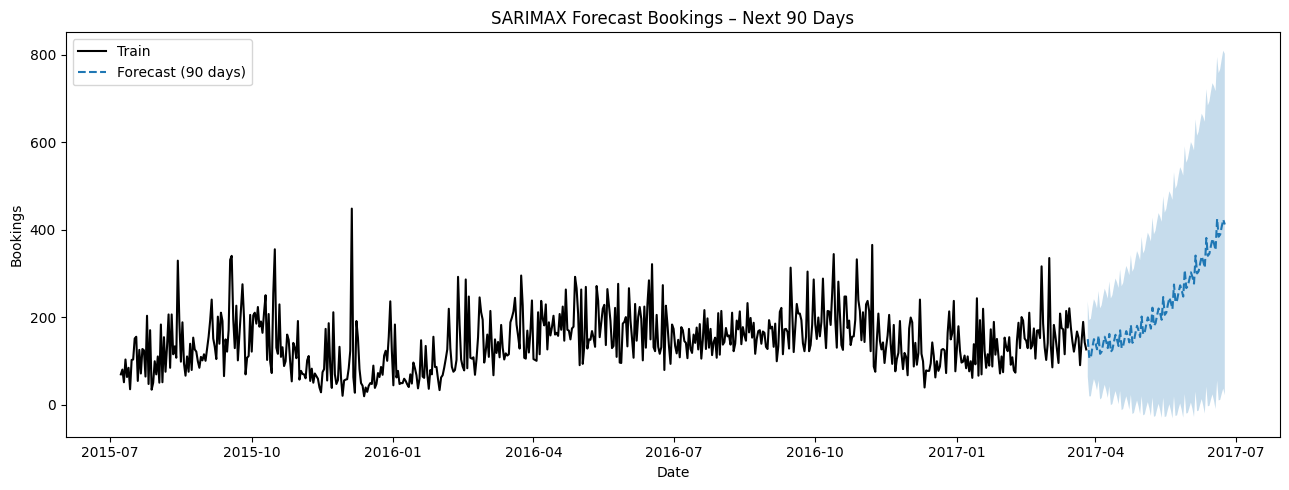

In [42]:
# =========================
# 9) PLOT 90-DAY FORECAST
# =========================
plt.figure(figsize=(13, 5))

plt.plot(y_train2, label="Train", color="black")

fc90 = forecasts[90]["mean"]
ci90 = forecasts[90]["ci"]

plt.plot(fc90, label="Forecast (90 days)", linestyle="--")
plt.fill_between(
    ci90.index,
    ci90.iloc[:, 0],
    ci90.iloc[:, 1],
    alpha=0.25
)

plt.title("SARIMAX Forecast Bookings – Next 90 Days")
plt.xlabel("Date")
plt.ylabel("Bookings")
plt.legend()
plt.tight_layout()
plt.show()
